<a href="https://colab.research.google.com/github/CiaraFarrellSETU/Dissertation_code/blob/main/vgg16_4classes_attempt2ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# libraries for files preparation
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import shutil

# libraries for CNN models and plotting
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
from PIL import Image
import tensorflow as tf
from keras import backend as K
from keras.models import load_model
from keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import zipfile

with zipfile.ZipFile('/content/gdrive/MyDrive/eyes.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/unzipp_d')  # Replace with desired destination directory

In [4]:
base_dir = '/content/unzipp_d/eyes'

train_dir = '/content/unzipp_d/eyes/train'
cat_train_dir = '/content/unzipp_d/eyes/train/cataract'
healthy_train_dir = '/content/unzipp_d/eyes/train/healthy'
entropion_train_dir = '/content/unzipp_d/eyes/train/entropion'
mas_train_dir = '/content/unzipp_d/eyes/train/mas'


test_dir = '/content/unzipp_d/eyes/test'
cat_test_dir = '/content/unzipp_d/eyes/test/cataract'
healthy_test_dir = '/content/unzipp_d/eyes/test/healthy'
entropion_test_dir = '/content/unzipp_d/eyes/test/entropion'
mas_test_dir = '/content/unzipp_d/eyes/test/mas'


val_dir = '/content/unzipp_d/eyes/valid'
cat_val_dir = '/content/unzipp_d/eyes/valid/cataract'
healthy_val_dir = '/content/unzipp_d/eyes/valid/healthy'
entropion_val_dir = '/content/unzipp_d/eyes/valid/entropion'
mas_val_dir = '/content/unzipp_d/eyes/valid/mas'


In [7]:
num_cat_train = len(os.listdir(cat_train_dir))
num_healthy_train = len(os.listdir(healthy_train_dir))
num_entropion_train = len(os.listdir(entropion_train_dir))
num_mas_train = len(os.listdir(mas_train_dir))


num_cat_test = len(os.listdir(cat_test_dir))
num_healthy_test = len(os.listdir(healthy_test_dir))
num_entropion_test = len(os.listdir(entropion_test_dir))
num_mas_test = len(os.listdir(mas_test_dir))

num_cat_val = len(os.listdir(cat_val_dir))
num_healthy_val = len(os.listdir(healthy_val_dir))
num_entropion_val = len(os.listdir(entropion_val_dir))
num_mas_val = len(os.listdir(mas_val_dir))

In [8]:
print("Total Training cat Images",num_cat_train)
print("Total Training healthy Images",num_healthy_train)
print("Total Training entropion Images",num_entropion_train)
print("Total Training mas Images",num_mas_train)
print("--")
print("Total test cat Images",num_cat_test)
print("Total test healthy Images",num_healthy_test)
print("Total test entropion Images",num_entropion_test)
print("Total test mas Images",num_mas_test)
print("--")
print("Total validation cat Images",num_cat_val)
print("Total validation healthy Images",num_healthy_val)
print("Total validation entropion Images",num_entropion_val)
print("Total validation mas Images",num_mas_val)
print("--")


total_train = num_cat_train+num_healthy_train+num_entropion_train+num_mas_train
total_validation = num_cat_val+num_healthy_val+num_entropion_val+num_mas_val
total_test = num_cat_test+num_healthy_test+num_entropion_test+num_mas_test
print("Total Training Images",total_train)
print("--")
print("Total Validation Images",total_validation)
print("--")
print("Total Testing Images",total_test)

Total Training cat Images 5290
Total Training healthy Images 1530
Total Training entropion Images 1470
Total Training mas Images 1470
--
Total test cat Images 179
Total test healthy Images 70
Total test entropion Images 70
Total test mas Images 70
--
Total validation cat Images 421
Total validation healthy Images 121
Total validation entropion Images 140
Total validation mas Images 41
--
Total Training Images 9760
--
Total Validation Images 723
--
Total Testing Images 389


In [11]:
os.listdir(base_dir)

['valid', 'test', 'train']

In [15]:
os.listdir(train_dir)

['cataract', 'entropion', 'mas', 'healthy']

In [18]:
BATCH_SIZE = 32
IMG_SIZE = (256  , 256)
train_directory = train_dir
val_directory = val_dir

In [19]:
train_datagen = ImageDataGenerator(rescale=1./255,
        rotation_range=0.2,
        shear_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        train_directory,
        target_size=IMG_SIZE,
        color_mode='grayscale',
        batch_size=32,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        val_directory,
        target_size=IMG_SIZE,
        color_mode='grayscale',
        batch_size=32,
        shuffle=False,
        class_mode='categorical')

Found 9760 images belonging to 4 classes.
Found 722 images belonging to 4 classes.


In [20]:
train_generator.class_indices

{'cataract': 0, 'entropion': 1, 'healthy': 2, 'mas': 3}

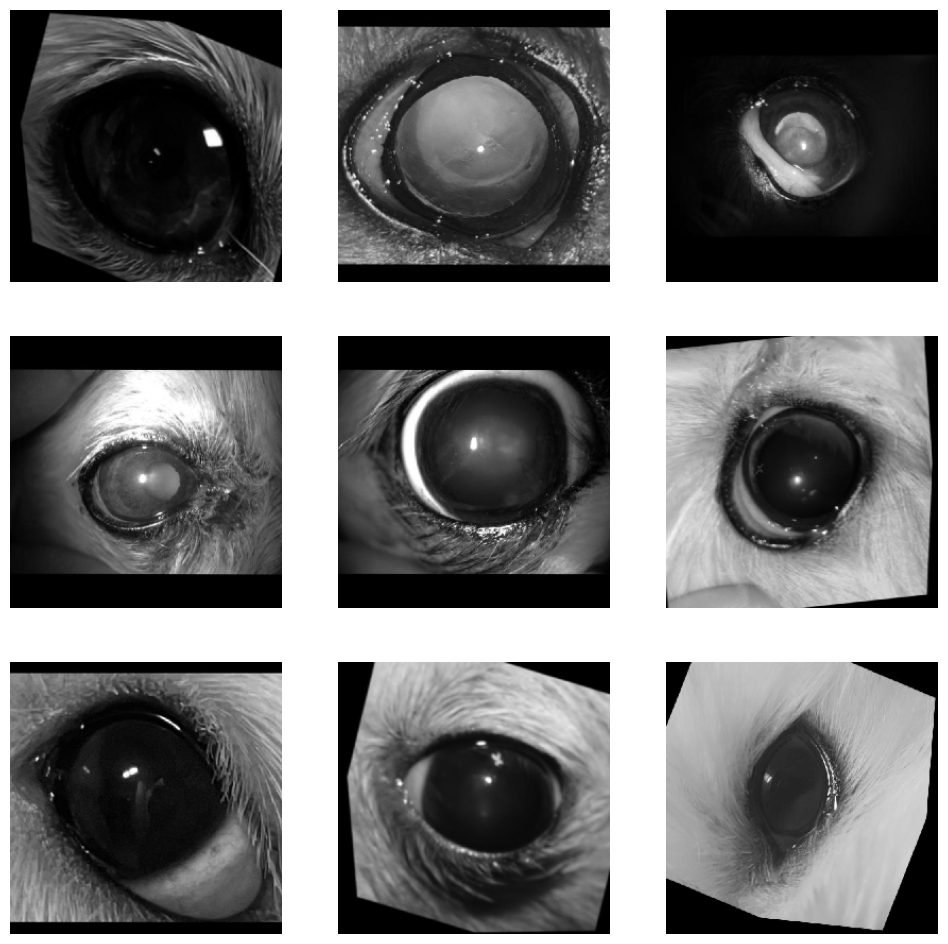

In [23]:
import numpy as np
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3,3, i+1)
    img, label = train_generator.next()
    plt.imshow(img[0], cmap='gray')
    dic = {'cataract': 0, 'entropion': 1, 'healthy': 2, 'mas': 3}
    plt.title(dic.get(np.where(label[0]==1)[0][0]))
    plt.axis('off')
plt.show()

In [24]:
def model1(IMG_SIZE):
    input_shape = IMG_SIZE + (1, )
    model = Sequential([
        Conv2D(32, (3, 3), activation="relu", padding='same',input_shape=input_shape),
        MaxPooling2D(pool_size = (2, 2)),
        Conv2D(32, (3, 3), padding='same', activation="relu"),
        MaxPooling2D(pool_size = (2, 2)),
        Conv2D(64, (3, 3), padding='same',activation="relu"),
        MaxPooling2D(pool_size = (2, 2)),
        Conv2D(64, (3, 3), padding='same',activation="relu"),
        MaxPooling2D(pool_size = (2, 2)),
        Conv2D(128, (3, 3), padding='same',activation="relu"),
        MaxPooling2D(pool_size = (2, 2)),
        Conv2D(128, (3, 3), padding='same',activation="relu"),
        MaxPooling2D(pool_size = (2, 2)),
        Conv2D(128, (3, 3), padding='same',activation="relu"),
        MaxPooling2D(pool_size = (2, 2)),
        Conv2D(256, (3, 3), padding='same',activation="relu"),
        MaxPooling2D(pool_size = (2, 2)),
        Flatten(),

        Dense(units=128, activation='relu'),
        Dense(units=64, activation='relu'),
        Dense(units=3, activation='softmax')
    ])
    return model

In [25]:
IMG_SIZE

(256, 256)

In [27]:
model = model1(IMG_SIZE)

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 128, 128, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 32, 32, 64)       

In [30]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [32]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [33]:
initial_epochs = 15
history = model.fit(train_generator, epochs=initial_epochs,
                     validation_data = validation_generator, callbacks=[early_stopping])

Epoch 1/15


InvalidArgumentError: Graph execution error:

Detected at node categorical_crossentropy/softmax_cross_entropy_with_logits defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-33-82a8177901c8>", line 2, in <cell line: 2>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2221, in categorical_crossentropy

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5579, in categorical_crossentropy

logits and labels must be broadcastable: logits_size=[32,3] labels_size=[32,4]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_train_function_3172]